# Assignment 2: Naive Bayes and KNN classifier

In this assignment you'll implement the Naive Bayes and KNN classifier to classify patients as either having or not having diabetic retinopathy. For this task we'll be using the same Diabetic Retinopathy data set which was used in the previous assignment on decision trees. The implementation details are up to you but, generally it is a good idea to divide your code up into helper functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log
from math import floor
from random import shuffle

In [2]:
class DataBind:
    def __init__(self, minimum, maximum, probYes, probNo):
        self.minimum = minimum
        self.maximum = maximum
        self.probYes = probYes
        self.probNo = probNo

In [3]:
class DataPoint:
    def __str__(self):
        return "< " + str(self.label) + ": " + str(self.features) + " >"
    def __init__(self, label, features):
        self.label = label # the classification label of this data point
        self.features = features

In [4]:
def get_data(filename):
    data = []
    file_data = pd.read_csv(filename, skipinitialspace=True, header=None)
    for i in range(0,len(file_data)):
        data.append(DataPoint(file_data.iloc[i,19],file_data.iloc[i,0:19]))
    return data

## Part 1: Naive Bayes Classifier

Naive Bayes (NB) classifier is a simple probabilistic classifier that is based on applying the Bayes' theorem and assumes a strong (naive) independence between features. The Diabetic Retinopath data set contains both categorical and continuous features. Dealing with categorical features has been already been discussed in detail in class. Continuous attributes, on the other hand, are more interesting to handle. Most commonly, this is done by assuming normal probability distribution over the feature values or by binning the attribute values in a fixed number of bins. In this assignment you'll be implementing the binning approach. For each continuous attribute, you'll construct 3 equal sized bins. For example, feature 5 ranges from `[1 - 120]` the 3 bins that you'll construct will be `[1 - 40]`, `[41 - 80]`, `[81 - 120]`.

In [5]:
# matrix of probability
def get_mat_prob(data):
    mat=[]
    size_data = len(data)
    yes_label = sum(x.label==1 for x in data)
    no_label = sum(x.label!=1 for x in data)
    for i in range(0,len(data[0].features)):
        data.sort(key = lambda x: x.features[i])
        minim = data[0].features[i]
        maxim = data[size_data - 1].features[i]
        sizebind = floor((maxim-minim)/3)
        max_bind_one = minim + sizebind
        max_bind_two = max_bind_one + sizebind + 1
        bind_one_yes = sum(x.features[i] >= minim and x.features[i] <= max_bind_one and x.label == 1 for x in data)
        bind_one_no = sum(x.features[i] >= minim and x.features[i] <= max_bind_one and x.label != 1 for x in data)
        bind_two_yes = sum(x.features[i] >= max_bind_one+1 and x.features[i] <= max_bind_two and x.label == 1 for x in data)
        bind_two_no = sum(x.features[i] >= max_bind_one+1 and x.features[i] <= max_bind_two and x.label != 1 for x in data)
        bind_three_yes = sum(x.features[i] >= max_bind_two+1 and x.features[i] <= maxim and x.label == 1 for x in data)
        bind_three_no = sum(x.features[i] >= max_bind_two+1 and x.features[i] <= maxim and x.label != 1 for x in data)
        rowCol = []
        # Ask to add 1 numerator and 1 to denominator (both label values (yes and no), also on final data)
        if bind_one_yes == 0 or bind_one_no == 0:
            rowCol.append(DataBind(minim,max_bind_one,(bind_one_yes+1)/(yes_label+1),(bind_one_no+1)/(no_label+1)))
        else:
            rowCol.append(DataBind(minim,max_bind_one,bind_one_yes/yes_label,bind_one_no/no_label))
        if bind_two_yes == 0 or bind_two_no == 0:
            rowCol.append(DataBind(max_bind_one+1,max_bind_two,(bind_two_yes+1)/(yes_label+1),(bind_two_no+1)/(no_label+1)))       
        else:
            rowCol.append(DataBind(max_bind_one+1,max_bind_two,bind_two_yes/yes_label,bind_two_no/no_label))
        if bind_three_yes == 0 or bind_three_no == 0:
            rowCol.append(DataBind(max_bind_two+1,maxim,(bind_three_yes+1)/(yes_label+1),(bind_three_no+1)/(no_label+1)))
        else:
            rowCol.append(DataBind(max_bind_two+1,maxim,bind_three_yes/yes_label,bind_three_no/no_label))
        mat.append(rowCol)
    return yes_label,no_label,np.transpose(mat)

In [6]:
def make_prob(mat,yes_prob,no_prob,data):
    bind = 3
    j = 0
    yes_prob_data = 1
    no_prob_data = 1
    sizeData = yes_prob + no_prob
    for i in range(0,len(data.features)):
        while j < bind :
            if data.features[i] <= mat[j][i].maximum and data.features[i] >= mat[j][i].minimum:
                yes_prob_data = yes_prob_data * mat[j][i].probYes
                no_prob_data = no_prob_data * mat[j][i].probNo
                break
            j = j + 1
        j = 0
    yes_prob_data = yes_prob_data * (yes_prob/sizeData)
    no_prob_data = no_prob_data * (no_prob/sizeData)
    if yes_prob_data > no_prob_data:
        return 1
    else:
        return 0

In [7]:
def split_data(data, fold):
    sizeStep = floor(len(data)/fold)
    finalStep = sizeStep
    i = 0
    j = 0
    folds = []
    while i < fold:
        data_fold = []
        while j < finalStep:
            data_fold.append(data[j])
            j = j + 1
        if i == fold-2:
            finalStep = len(data)
        else:
            finalStep = finalStep + sizeStep
        folds.append(data_fold)
        i = i + 1
    return folds

In [8]:
def get_accurracy_bayes(data):
    fold = 5
    i = 0
    j = 0
    sumIncorrect = 0
    errorAverage = 0
    
    # making folds
    array_fold = np.array_split(data,fold)
    while i < fold:
        train_set = array_fold[i+1:fold]+array_fold[0:i] #1,2,3,4 - 2,3,4,0
        train_set_single = [x for lst in train_set for x in lst]
        test_set = array_fold[i] #0 - 1
        yes_prob, no_prob, m = get_mat_prob(train_set_single)
        while j < len(test_set):
            if data[j].label != make_prob(m,yes_prob,no_prob,data[j]):
                sumIncorrect = sumIncorrect + 1
            j = j + 1
        errorAverage = errorAverage + sumIncorrect/len(test_set)
        sumIncorrect = 0
        j = 0
        i = i + 1
    return (1 - (errorAverage/fold))

In [9]:
# your code goes here
d = get_data("messidor_features.txt")
print(get_accurracy_bayes(d)*100)

63.77112742330133



## Part 2: K Nearest Neighbor (KNN) Classifier

The KNN classifier consists of two stages:-
- In the training stage, the classifier takes the training data and simply memorizes it
- In the test stage, the classifier compares the test data with the training data and simply returns the maximum occuring label of the k nearest data points.

The distance calculation method is central to the algorithm, typically Euclidean distance is used but other distance metrics like Manhattan distance can also be used. In this assignment you'll be implementing the classifier using the Euclidean distance metric. It is important to note that, Euclidean distance is very sensitive to the scaling of different attributes hence, before you can build your classifier you have to normalize the values of each feature in the data set.

In [10]:
def get_norm_data(filename):
    data = []
    file_data = pd.read_csv(filename, skipinitialspace=True, header=None)
    # Normalize data
    for i in range(0,len(file_data.columns)):
        minimum = min(file_data.iloc[:,i])
        maximum = max(file_data.iloc[:,i])
        for j in range(0,len(file_data)):
            file_data.iloc[j,i] = (file_data.iloc[j,i] - minimum)/(maximum - minimum)
    # List of data points
    for i in range(0,200):
        data.append(DataPoint(file_data.iloc[i,19],file_data.iloc[i,0:19]))
    return data


In [11]:
def euclidian_distance(dataX, dataY):
    distance = 0
    for i in range(0,len(dataX.features)):
        distance = distance + pow(dataX.features[i]-dataY.features[i],2)
    return pow(distance,0.5)

In [12]:
def knn(train_set, dataPoint,k):
    if sum([x.label for x in sorted(train_set, key = lambda y: euclidian_distance(y, dataPoint))][:k]) > k/2:
        return 1
    else:
        return 0

In [14]:
def get_train_test(array_fold,fold):
    i = 0
    super_train_set = []
    test_set = []
    while i < fold:
        train_set = array_fold[i+1:fold]+array_fold[0:i] #1,2,3,4 - 2,3,4,0
        super_train_set.append([x for lst in train_set for x in lst])
        test_set.append(array_fold[i])
        i = i + 1
    return super_train_set, test_set

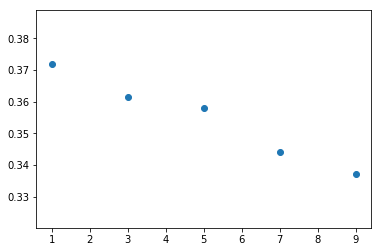

In [15]:
def get_best_k(data,topK):
    fold = 5
    i = 0
    j = 0
    x = 0
    sumIncorrect = 0
    errorK = 0
    
    # making folds
    array_fold = np.array_split(data,fold)
    # making k list
    kList = np.arange(1,topK,2)
    kError = []
    super_train_set, test_set = get_train_test(array_fold,fold)
    while x < len(kList):
        k = kList[x]
        while i < fold:
            while j < len(test_set[i]):
                if test_set[i][j].label != knn(super_train_set[i],test_set[i][j],k):
                    sumIncorrect = sumIncorrect + 1
                j = j + 1
            errorK = errorK + sumIncorrect/len(test_set[i])
            sumIncorrect = 0
            j = 0
            i = i + 1
        kError.append(errorK/fold)
        errorK = 0
        i = 0
        x = x + 1
    return kList, kError, kList[np.argmin(kError)]

kList,kError,k=get_best_k(d,10)
plt.scatter(kList,kError)
plt.show()

In [16]:
def get_accurracy_bayes(data, k, fold):
    i = 0
    j = 0
    sumIncorrect = 0
    errorK = 0
    
    # making folds
    array_fold = np.array_split(data,fold)

    super_train_set, test_set = get_train_test(array_fold,fold)
    while i < fold:
        while j < len(test_set[i]):
            if test_set[i][j].label != knn(super_train_set[i],test_set[i][j],k):
                sumIncorrect = sumIncorrect + 1
            j = j + 1
        errorK = errorK + sumIncorrect/len(test_set[i])
        sumIncorrect = 0
        j = 0
        i = i + 1
    return (1 - (errorK/fold))

In [17]:
d = get_norm_data("messidor_features.txt")
kList,kError,k=get_best_k(d,10)
print(get_accurracy_bayes(d,k,5)*100)

61.5
